#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature 가 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

* 라이브러리 로딩

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [16]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [19]:
# 불러오기
data01 = pd.read_csv('data01_train.csv')

# subject 제거
data01 = data01.drop(columns='subject')

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [23]:
data01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [24]:
data01.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [25]:
data01.shape

(5881, 562)

### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [28]:
display(data01['Activity'].value_counts())
data01['Activity'].value_counts(normalize=True)

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

Activity
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: proportion, dtype: float64

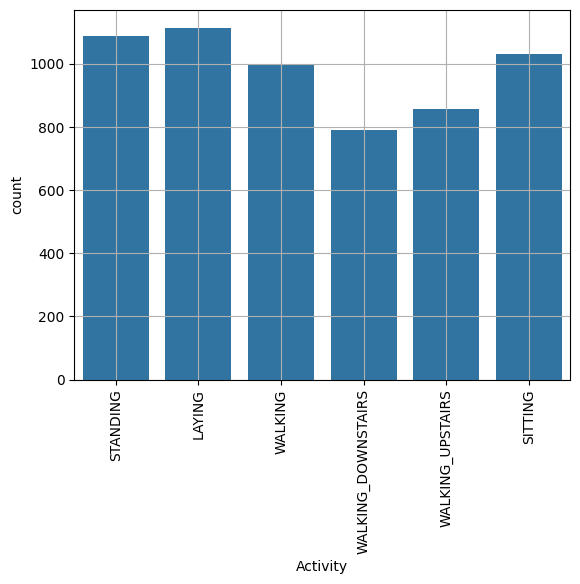

In [29]:
sns.countplot(x='Activity', data=data01)
plt.xticks(rotation = 90)
plt.grid()
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [35]:
target = 'Activity'
x = data01.drop(columns=target)
y = data01[target]

#### 2) 모델링

In [37]:
# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [38]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [39]:
y_pred = model.predict(x_test)

#### 3) 변수 중요도 추출

In [41]:
from sklearn.metrics import *

In [42]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[330   0   0   0   0   1]
 [  0 279  13   0   0   0]
 [  0  12 319   0   0   0]
 [  0   0   0 293   3   1]
 [  0   0   0   2 233   4]
 [  0   0   0   1   3 271]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.96      0.96      0.96       292
          STANDING       0.96      0.96      0.96       331
           WALKING       0.99      0.99      0.99       297
WALKING_DOWNSTAIRS       0.97      0.97      0.97       239
  WALKING_UPSTAIRS       0.98      0.99      0.98       275

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



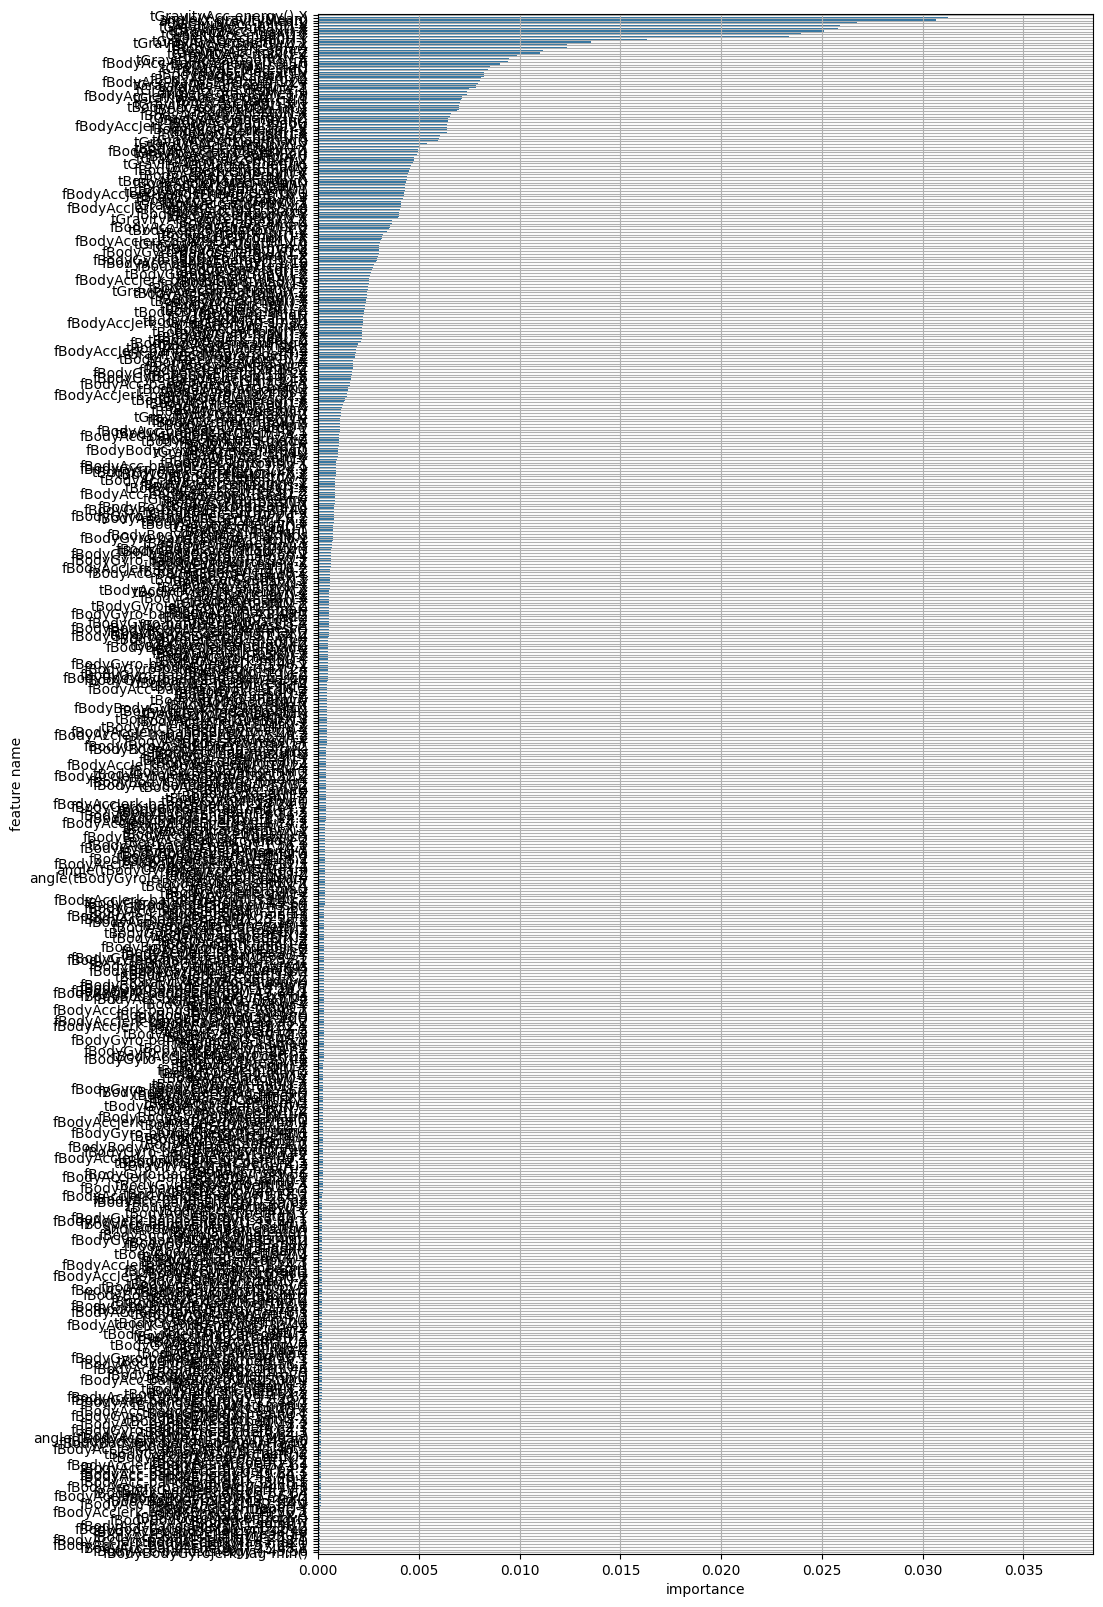

In [43]:
gjr = plot_feature_importance(model.feature_importances_,list(x))

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [47]:
top5 = gjr.head()
top5

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.036630
1,"angle(Y,gravityMean)",0.031279
2,"angle(X,gravityMean)",0.030661
3,tGravityAcc-min()-X,0.026742
4,tGravityAcc-mean()-X,0.025874


In [48]:
worst5 = gjr.tail()
worst5

,feature_name,feature_importance
556,tBodyAccJerkMag-max(),0.000094
557,"fBodyAccJerk-bandsEnergy()-57,64.1",0.000090
558,"fBodyAcc-bandsEnergy()-25,48.1",0.000084
559,"fBodyAcc-bandsEnergy()-49,56",0.000079
560,fBodyBodyGyroJerkMag-min(),0.000059


#### 2) 상위 5개 변수에 대한 분석

In [50]:
def gg(a,b = 'Activity'):
    feature = a
    target = b # 미션2에서는 'is_Dynamic'
    sns.kdeplot(x = feature, data = data01, hue = target, common_norm = False)
    plt.grid()
    plt.show()

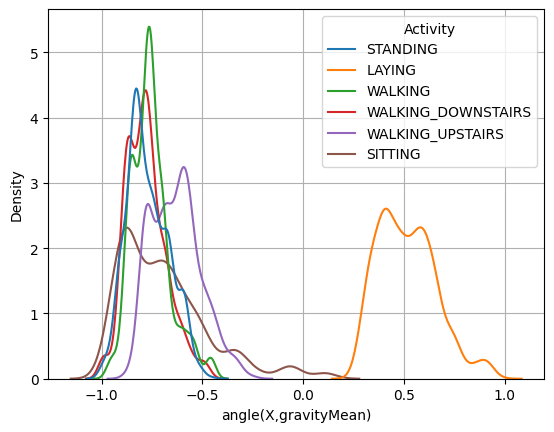

In [51]:
# (X축 방향 - 중력가속도 평균) 벡터 사이의 각도
gg('angle(X,gravityMean)')

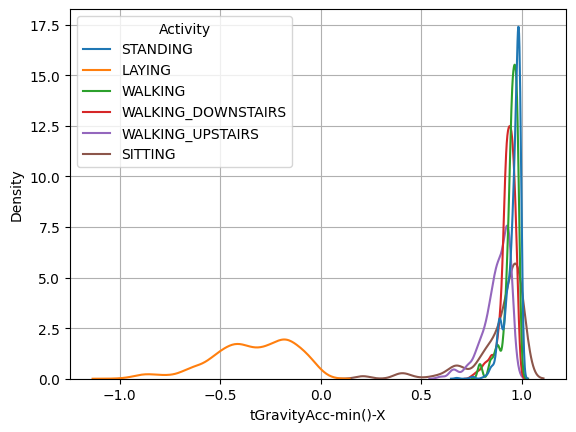

In [52]:
# X축 방향 중력가속도 최소값
gg('tGravityAcc-min()-X')

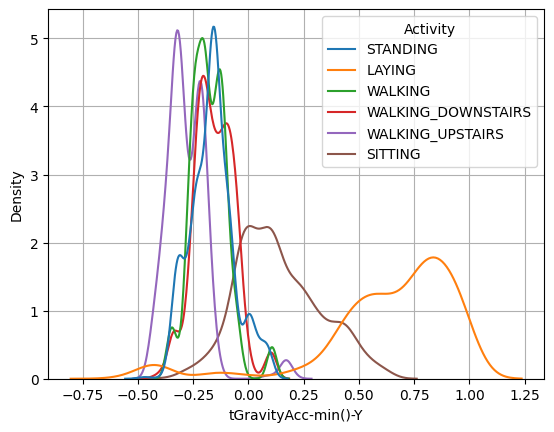

In [53]:
# Y축 방향 중력가속도 최소값
gg('tGravityAcc-min()-Y')

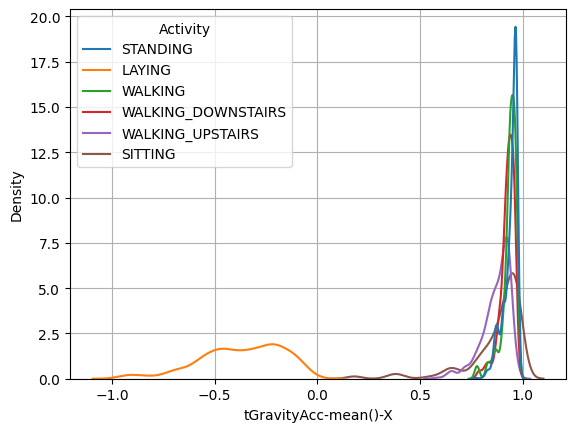

In [54]:
# X축 방향 중력가속도 평균
gg('tGravityAcc-mean()-X')

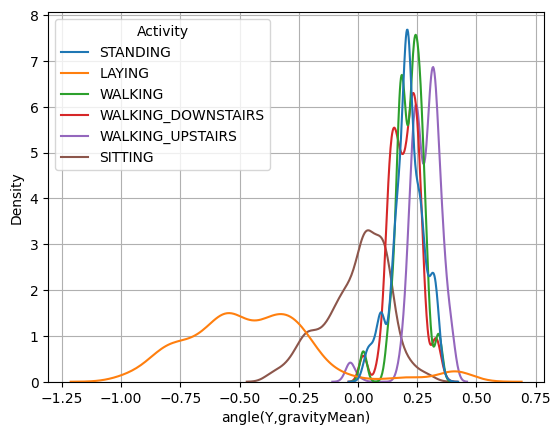

In [55]:
# (Y축 방향 - 중력가속도 평균) 벡터 사이의 각도
gg('angle(Y,gravityMean)')

#### 3) 하위 5개 변수에 대한 분석

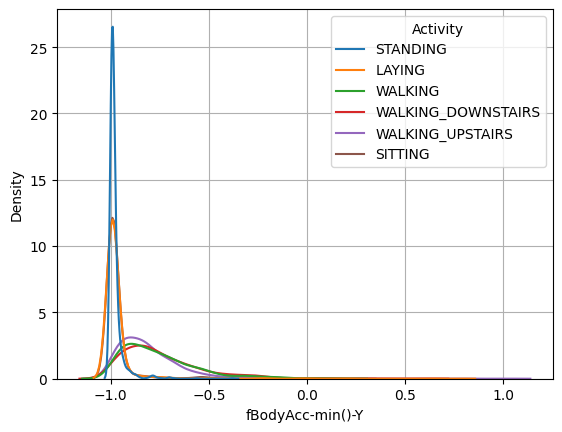

In [57]:
# 고속퓨리에변환을 거친 Y축 방향 가속도 최소값
gg('fBodyAcc-min()-Y')

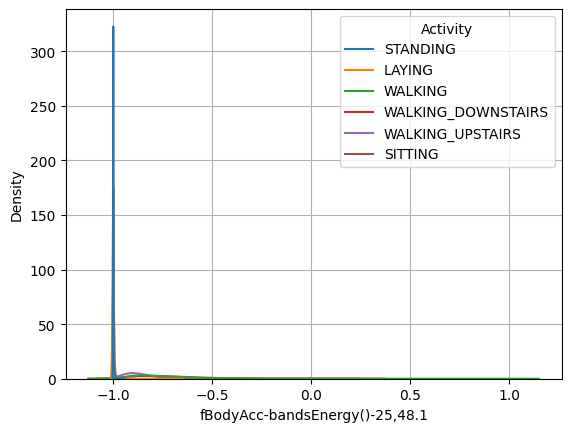

In [58]:
# 고속퓨리에변환을 거친 25~48 구간의 시간갭1에 대한  에너지 밴드 가속도
gg('fBodyAcc-bandsEnergy()-25,48.1')

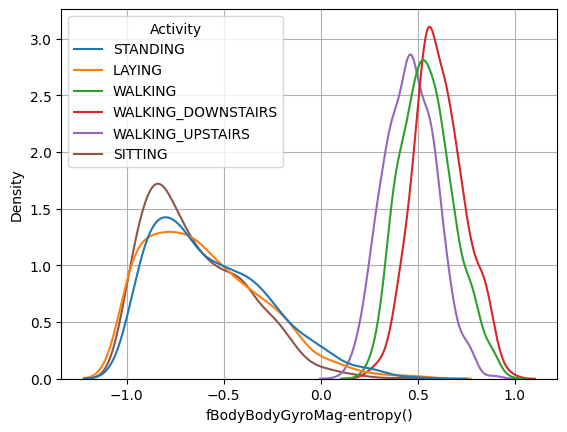

In [59]:
# 유클리드 노름을 사용한 고속퓨리에변환을 거친 각속도 3차원 신호 크기 신호의 엔트로피
gg('fBodyBodyGyroMag-entropy()')

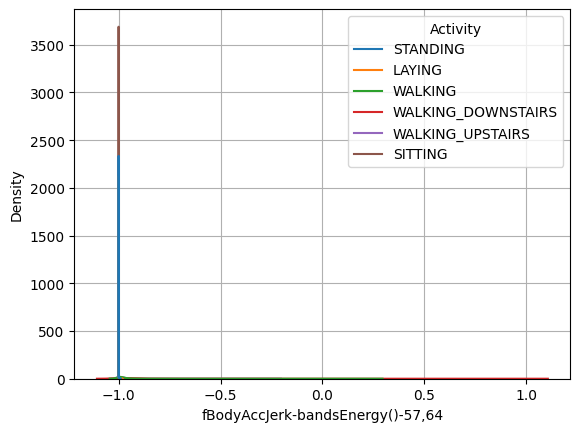

In [60]:
# 고속퓨리에변환을 거친 57~64 구간의 에너지 밴드 가속도 변화비율
gg('fBodyAccJerk-bandsEnergy()-57,64')

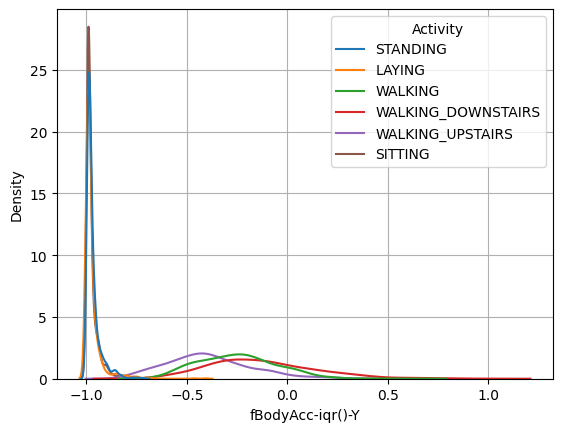

In [61]:
# 고속퓨리에변환을 거친 Y축 방향 가속도 3사분위수 - 1사분위수
gg('fBodyAcc-iqr()-Y')

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
     
  
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
 
  지워요@@@@@@@@@@@@@@@@@@@@@@@ '변수그룹' 나오면 지워요
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [67]:
# is_dynamic 추가
tmp= data01['Activity']
#(np.where(tmp == ('STANDING','SITTING','LAYING'), 0, 1)
data01['is_dynamic'] = np.where((tmp=='STANDING') | (tmp=='SITTING') | (tmp=='LAYING'), 0, 1)
data01.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [69]:
target = 'is_dynamic'
x = data01.drop(columns=[target,'Activity'])
y = data01[target]

In [70]:
# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [71]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [72]:
y_pred = model.predict(x_test)

In [73]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[952   2]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



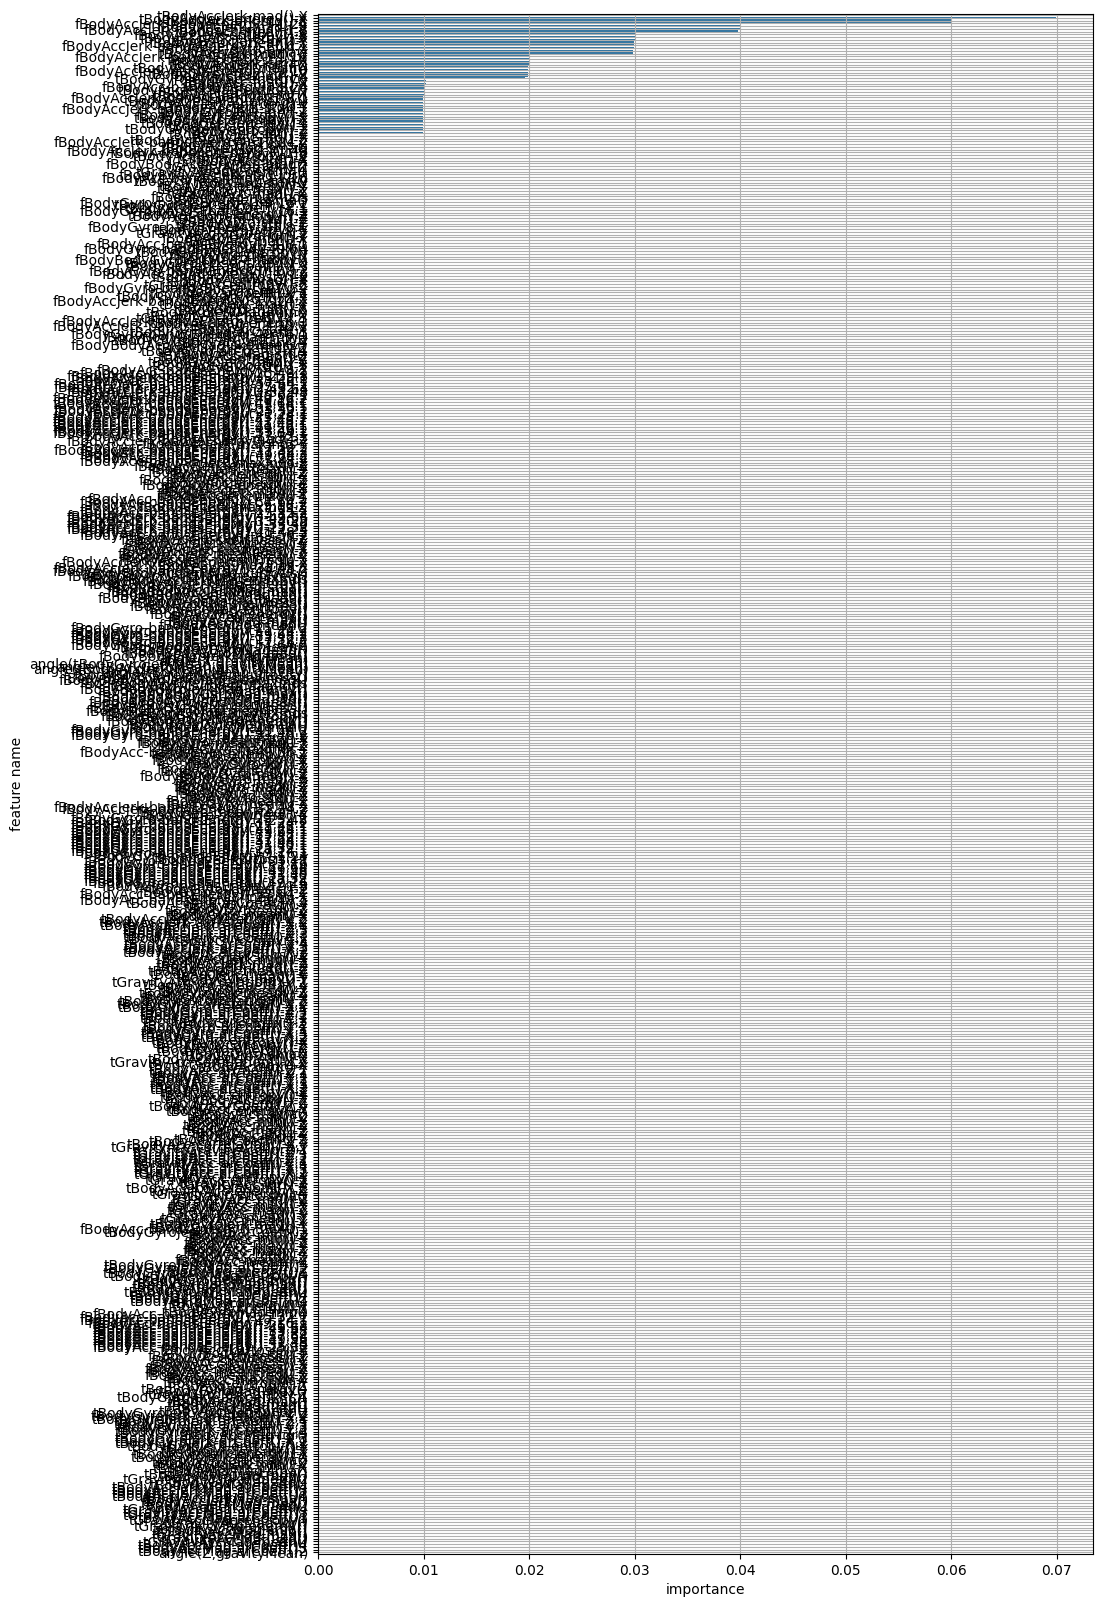

In [74]:
gjr2 = plot_feature_importance(model.feature_importances_,list(x))

#### 3) 변수중요도 상위 5개 분석

In [76]:
top5 = gjr2.head()
top5

,feature_name,feature_importance
0,tBodyAccJerk-mad()-X,0.069941
1,tBodyAccJerk-energy()-X,0.069921
2,tBodyAccJerk-std()-X,0.060078
3,"fBodyAccJerk-bandsEnergy()-1,24",0.060029
4,fBodyAccJerk-mad()-X,0.039951


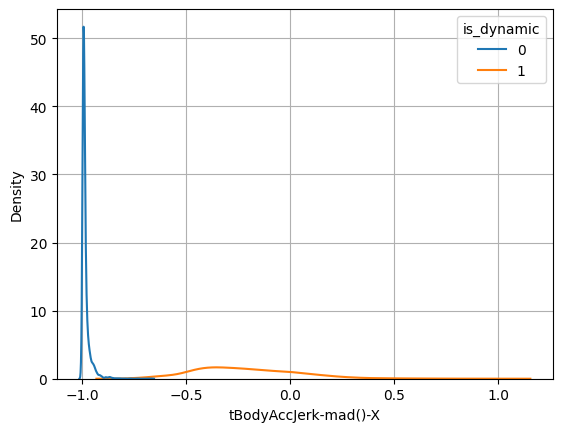

In [77]:
# X축 방향 가속도변화비율 평균절대편차
gg('tBodyAccJerk-mad()-X','is_dynamic')

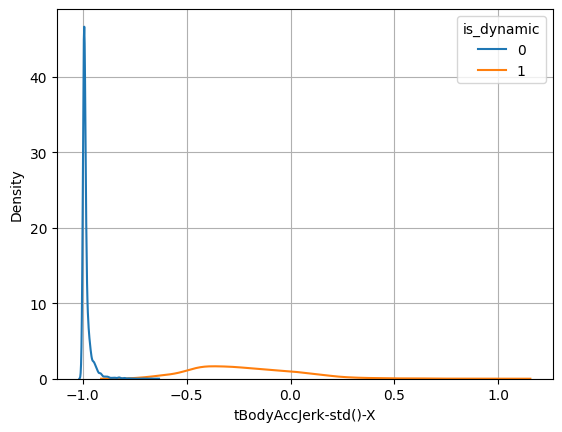

In [78]:
# X축 방향 가속도변화비율 표준편차
gg('tBodyAccJerk-std()-X','is_dynamic')

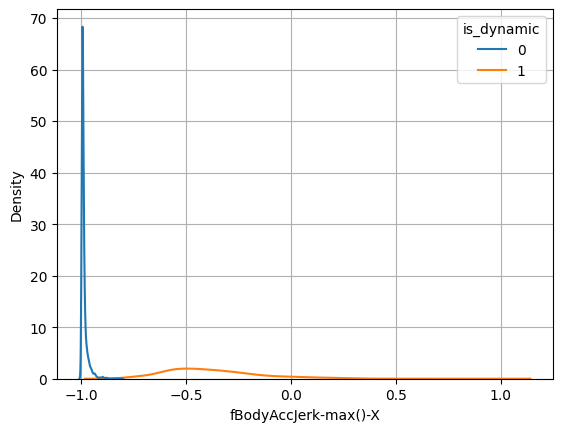

In [79]:
# 고속퓨리에변환을 거친 X축 방향 가속도변화비율 최대값
gg('fBodyAccJerk-max()-X','is_dynamic')

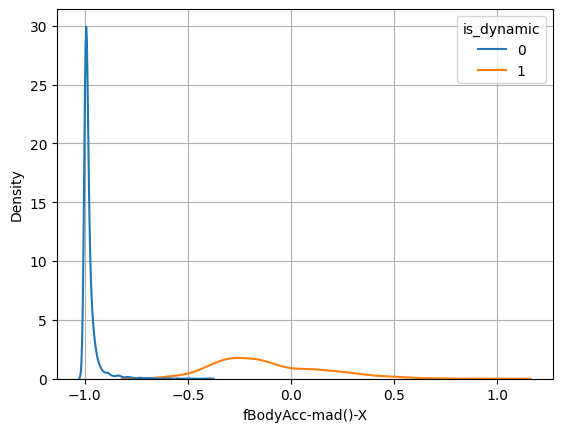

In [80]:
# 고속퓨리에변환을 거친 X축 방향 가속도 평균절대편차
gg('fBodyAcc-mad()-X','is_dynamic')

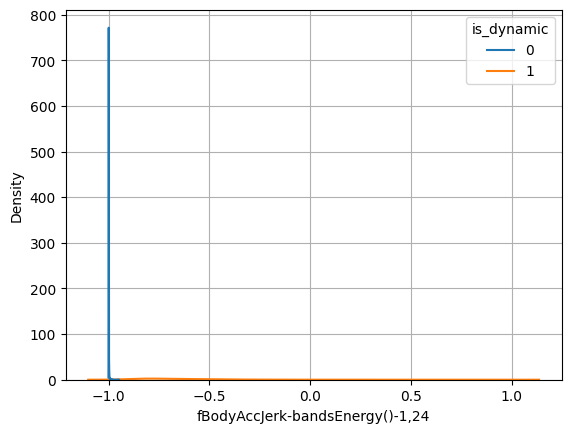

In [81]:
# 고속퓨리에변환을 거친 1~24 구간의 에너지 밴드 가속도 변화비율
gg('fBodyAccJerk-bandsEnergy()-1,24','is_dynamic')